## Recorder

Date: 17/05/2021, 20/09/2021, 24/02/2022 (v0.6), 16/02/2023 (v0.7)

### Description

This notebook illustrates various ways of audio recording in a Jupyter notebook
- either directly via command line
- either via the **iRecorder()** GUI 

#### iRecorder()

is a simple Jupyter Lab / ipywidgets based GUI for speech recordings.
- Record and Play Buttons
- set recording time and sampling frequency
- Save (selected part of) current recording to a named file

#### CAVEATS

A Jupyter notebook is not the optimal environment for interactive Audio I/O ,
due to a 3 way potential conflict between browser / latencies and rules in jupyter client-server architecture 
/ notebook.
Due to these various policy level, the notebook is never fully in control of what happens.
Moreover audio hardware capabilties vary drastically between machines.
For playback, resulting issues are manageable.  For recording, things are a bit more messy.

Issues that you may encounter include:
- lead time in recordings:  there may be a discrepancy between the prompt to start recording and the actual start of the recording; this can be substantial (a few 100 msec), just discard these unwanted parts when saving
- autoplay and autonormalize are features that can be overruled by the browser; you may see different behavior on Chrome vs. Firefox .. 

#### Writing Files on Colab

You can write into your temporarily allocated space on colab.
However, if you want to reuse files later, the way to go is to mount your google drive first and
write them there.
With the following lines of code, you will be able to access your personal google drive
> from google.colab import drive    
> drive.mount('/content/gdrive')    
> gdrive_path = '/content/gdrive/My Drive/'    


In [1]:
# if needed, uncomment the pip install command to install pyspch -- it is required!
#
#!pip install git+https://github.com/compi1234/pyspch.git
#
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display, clear_output, Audio, HTML
import ipywidgets as widgets
import numpy as np
import librosa

# verify the IPython version
import IPython
Audio_args = {'normalize':False}
if IPython.version_info[0] < 6:
    print("Warning: you are using IPython<6 which has limited Audio support\n")
    Audio_args = {}
import pyspch.core as Spch
import pyspch.sp as Sps
import pyspch.display as Spd
import pyspch.display.interactive as SpGui

## Setting up Google Drive, so that you can save files for future usage
You have two options for storing (recorded) files:
1. Locally inside your current session: just give a filename
2. On your Google Drive
    + first mount Google Drive for usage inside this notebook (as in the cell below)
    + A file in your Google Drive, e.g. 'MyFile.ext' is accessible in this notebook as:
        > 'gdrive/MyDrive/MyFile.ext'
        
By default we are setting up linkage with your Google Drive if on colab.  Don't execute if you don't need it.

In [3]:
try:
    from google.colab import drive    
    drive.mount('/content/gdrive') 
except:
    None

In [4]:
beep1,_ = Sps.synth_signal(sigtype='sin', freq=800.0, amp=.25,sample_rate=8000., dur=0.2)
beep1.shape
Spch.audio.play(beep1,sample_rate=8000)

In [13]:
def record_after_beep(rec_time=2.0,beep=None,sample_rate=8000):
    if beep is None:
        beep,_ = Sps.synth_signal(sigtype='sin', freq=800.0, amp=.5,sample_rate=8000., dur=0.2)
    print("Record for %.2f seconds after the beep\n"%rec_time)
    Spch.audio.play(beep,sample_rate=8000,wait=True)
    rec_data  = Spch.audio.record(rec_time,sample_rate)
    return rec_data, sample_rate

In [4]:
y,sr = Spch.audio.load("../data/coding/f2.wav")

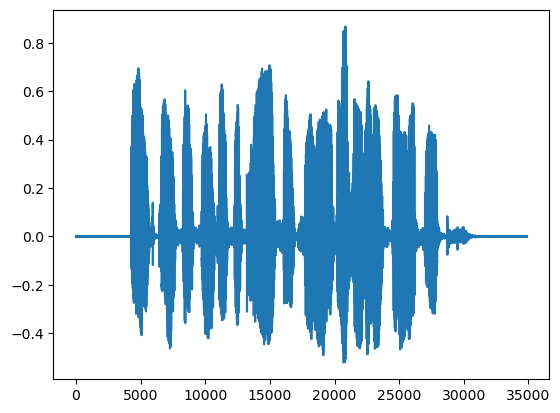

In [5]:
plt.plot(y)

In [8]:
SpGui.iSpectrogram()

iSpectrogram(children=(VBox(children=(Output(layout=Layout(border_bottom='solid 1px black', border_left='solid…

In [117]:
def audio_cut(y,sr=8000,t1=0.,t2=None):
    N = len(y)
    i1 = max(0,int(t1*sr))
    if t2 is None:
        i2 = N
    else: 
        i2 = min(int(t2*sr),N)
    return(y[i1:i2])
        
    
def audio_trim(y,sr=8000,threshold=None,safety=.0):
    '''
    trim a file for noise at both ends, given a magnitude threshold (frame based energy)
    and saftey margin of safety seconds
    '''
    shift = .01
    en = Sps.energy(y,shift=shift,mode='magnitude').flatten()
    if threshold is None:
        noise_lev = (np.sum(en[0:2]) + np.sum(en[-3:]) ) / 6.
        spch_lev = np.max(en)
        threshold = max(noise_lev*2,spch_lev/100)  # trailing noise +6dB, max spch -40dB
        #print("threshold: ",threshold,noise_lev,spch_lev)
    threshold_test = np.nonzero(en>threshold)
    frame1 = np.min(threshold_test)
    frame2 = np.max(threshold_test)
    print(frame1,frame2)
    t1 = max(0.0, frame1*shift-safety)
    t2 = min(len(y)/float(sr), frame2*shift+safety)
    print(t1,t2)
    return( audio_cut(y,sr,t1,t2) )

52 380
0.52 3.8000000000000003


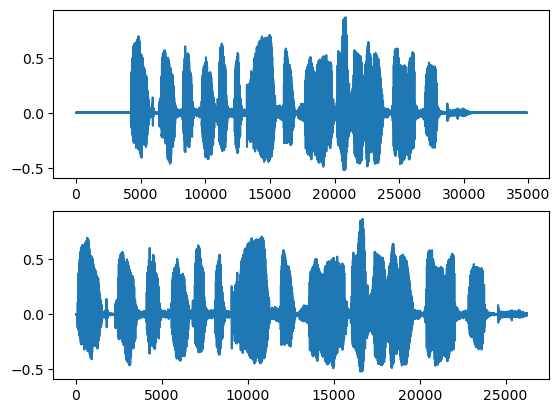

In [118]:
y1 = audio_trim(y)
f,ax = plt.subplots(2)
ax[0].plot(y)
ax[1].plot(y1)
Spch.audio.play(y,sample_rate=sr,wait=True)
Spch.audio.play(y1,sample_rate=sr,wait=True)

In [125]:
help(Spd.PlotSpgFtrs)

Help on function PlotSpgFtrs in module pyspch.display.display:

PlotSpgFtrs(wavdata=None, spgdata=None, segdata=None, line_ftrs=None, img_ftrs=None, row_heights=None, spglabel='Frequency', line_labels=None, img_labels=None, sample_rate=1.0, shift=0.01, dy=1, frames=None, Legend=False, **kwargs)
    General Purpose multi-tier plotting routine of speech signals.
    The figure contains
     - waveform + spectrogram (mandatory)
     - segmentations (list, optional)
     - img features (list, optional)
     - line features (list, optional)



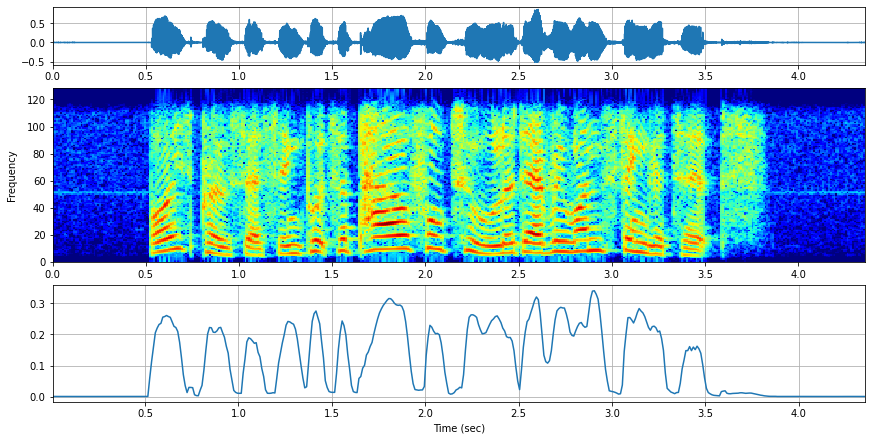

In [126]:
S = Sps.spectrogram(y,sample_rate=sr)
en = Sps.energy(y,sr=sr,mode='magnitude')
Spd.PlotSpgFtrs(y,S,sample_rate=sr,line_ftrs=en)

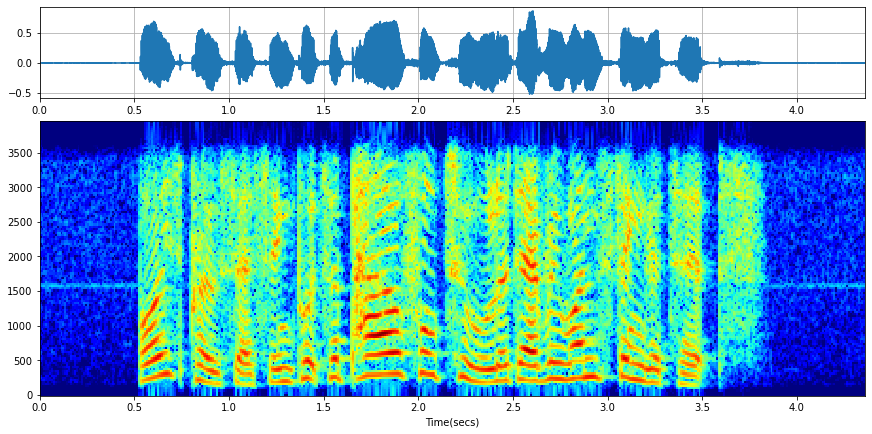

In [120]:
S1 = Sps.spectrogram(y1,sample_rate=sr)
Spd.PlotSpg(S1,y1,sample_rate=sr)

53 348


array([ 53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 153, 154, 155, 156,
       157, 158, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 252,
       253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
       266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278,
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291,
       292, 293, 294, 295, 306, 307, 308, 309, 310, 311, 312, 31

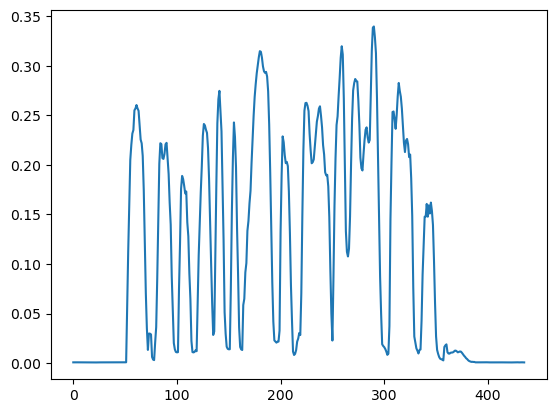

In [88]:
y,sr = Spch.audio.load("../data/coding/f2.wav")
#y,sr = Spch.audio.load("../data/coding/f1.wav")
en = Sps.energy(y,mode='magnitude').T
tst,_ = np.nonzero(en>.1)
print(np.min(tst), np.max(tst))
plt.plot(en)
tst

In [87]:
plt.plot(tst.T)

AttributeError: 'tuple' object has no attribute 'T'

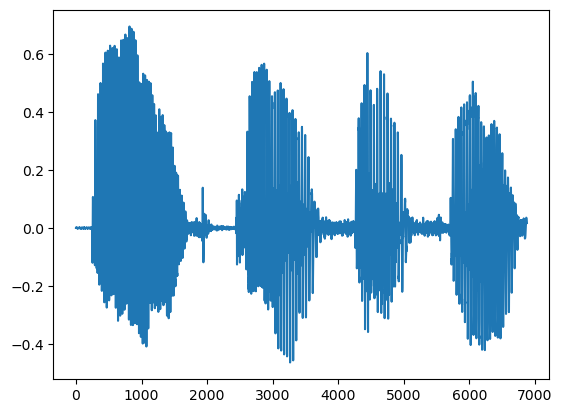

In [15]:
y1 = audio_cut(y,t1=0.5,t2=1.36)
Spch.audio.play(y1,sample_rate=sr)
plt.plot(y1)

Record for 4.00 seconds after the beep



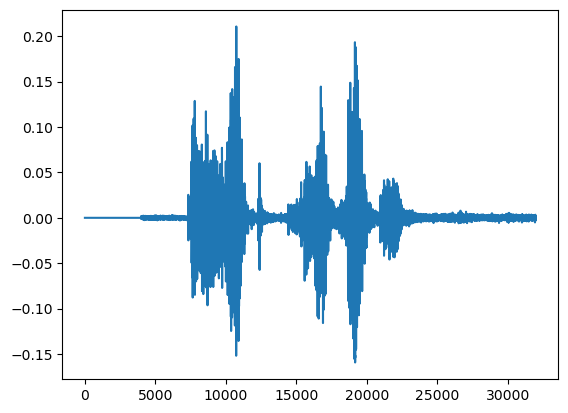

In [24]:
x,fs = record_after_beep(rec_time=4.0)
plt.plot(x)
Spch.audio.play(x,sample_rate=fs)

## 1. Recording via command line in *spchlab* 
- specify sample rate and recording time
- call Spch.audio.record()
- listen to / save the data

In [25]:
ref1= x

In [23]:
test1 = x

Recording now for 2.00 seconds on 1 channel(s)
Recording complete


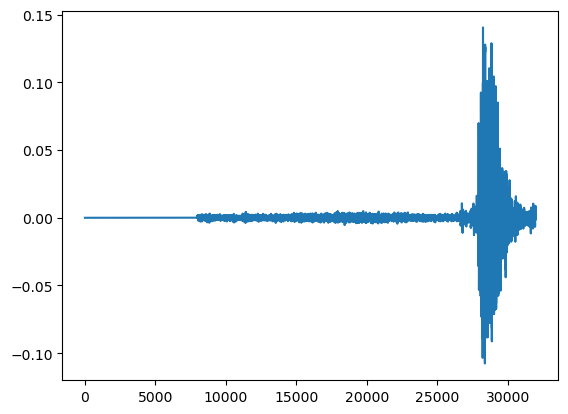

In [8]:
sample_rate = 16000
rec_time = 2.0
rec_data  = Spch.audio.record(rec_time,sample_rate)
plt.plot(rec_data)

In [9]:
# listen to the recorded audio via the Audio widget
display(Audio(data=rec_data,rate=sample_rate,normalize=False))

In [ ]:
# Save you recording to disk
#filename = "MyRecording.wav"
#Spch.audio.save(filename,rec_data,sample_rate)

## 2. Record via the iRecorder() GUI
Normally you should start iRecorder() without any arguments.   
Only in case you want to modify the size of the spectrogram and/or GUI, you may want to use the parameters *figsize* and *dpi*.
In the GUI you have:
- Record Section:
    + Play, Record, Stop buttons
    + input for recording time and sampling frequency
- Save Section:
    + filename
    + start and end times of section to be saved

In [16]:
SpGui.iRecorder()

iRecorder(children=(Output(layout=Layout(border_bottom='solid 1px black', border_left='solid 1px black', borde…

In [19]:
!dir \content

 Volume in drive C is Windows
 Volume Serial Number is 28FF-B9DA

 Directory of C:\



File Not Found


In [3]:
ywav = ref1
xwav = test1
sr = 8000
n_mels = None
shift=0.01
length=0.03
n_shift = int(shift*sr)
n_length = int(length*sr)
#
xspg = Sps.spectrogram(xwav,sample_rate=sr,f_shift=shift,preemp=0.,n_mels=None)
xmel = Sps.spectrogram(xwav,sample_rate=sr,f_shift=shift,n_mels=24)
xmelcep = Sps.melcepstrum(S=xspg)
yspg = Sps.spectrogram(ywav,sample_rate=sr,f_shift=shift,preemp=0.,n_mels=None)
ymel = Sps.spectrogram(ywav,sample_rate=sr,f_shift=shift,n_mels=24)
ymelcep = Sps.melcepstrum(S=yspg)

NameError: name 'ref1' is not defined

In [47]:
xmelcep.shape

(13, 400)

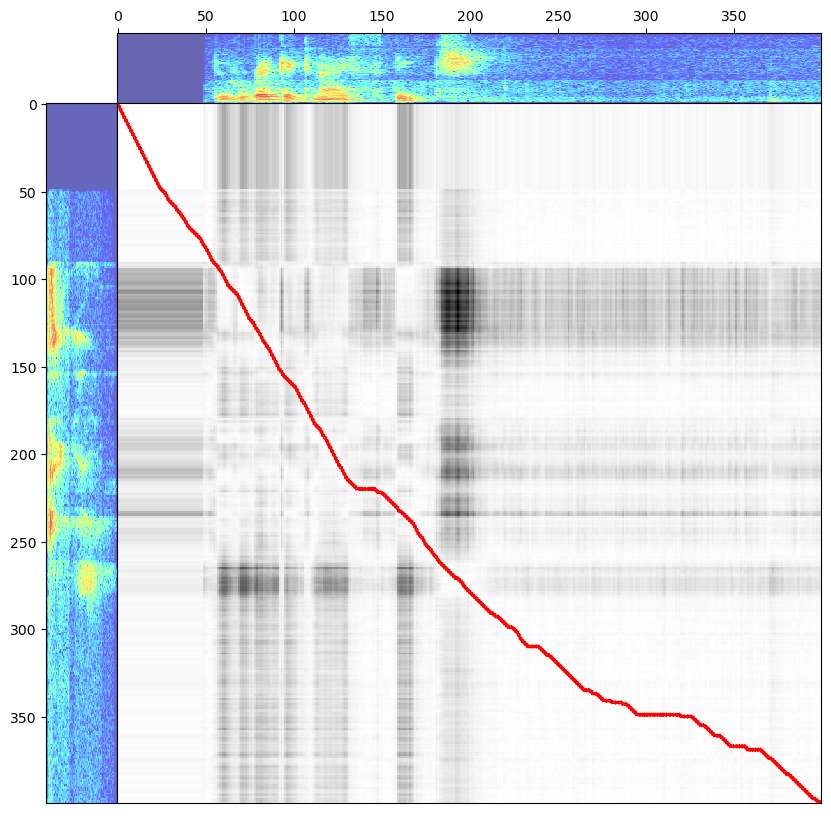

In [48]:
import pyspch.dtw as dtw
plt_args = {'fig_width':10,'ftr_scale':.1,'ftr_args':{'cmap':'jet','edgecolor':None},
            'xy_args':{'cmap':'Greys','alpha':1} }
xftrs = xmelcep[1:,:].T
yftrs = ymelcep[1:,:].T
cost,trace,ld_matrix,cd_matrix,_ = dtw.dtw(xftrs,yftrs,trans='ITA',result='details')
fig = dtw.plot_trellis(xy_mat=ld_matrix,trace=trace,y=yspg.T,x=xspg.T,**plt_args)
fig

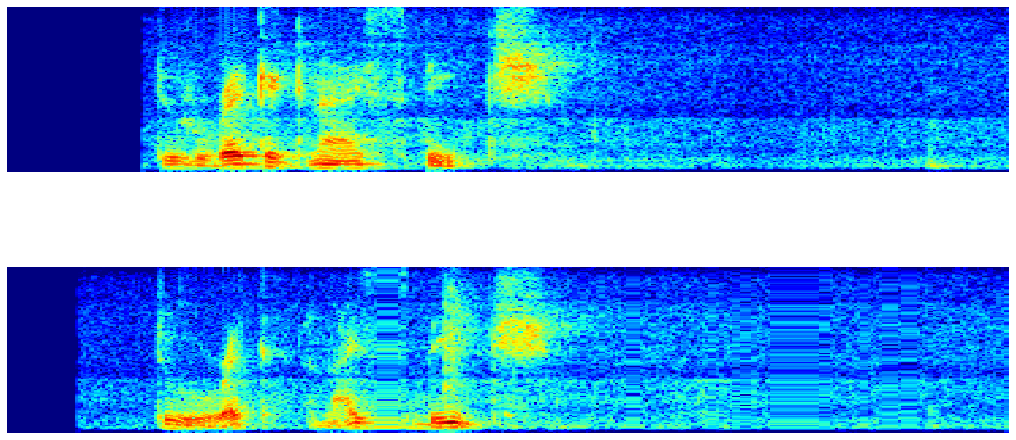

In [42]:
xspg_wp,yspg_wp = dtw.warp(xspg.T,yspg.T,trace)
dtw.plot_align(xspg_wp,yspg_wp,None,cmap='jet',down_sample=3,figsize=(14,6))

In [43]:
import librosa
def glim_synt(x,sample_rate=8000,shift=0.01):
    # dB to magnitude
    x_mag = librosa.db_to_power(x) **0.5
    hop_length = int(shift*sample_rate)
    xsyn = librosa.griffinlim(x_mag,hop_length=hop_length)
    return(xsyn)

Original 'x'


Warped 'x'


Original 'y'


Warped 'y'


Duo Speech x_wp+y_wp


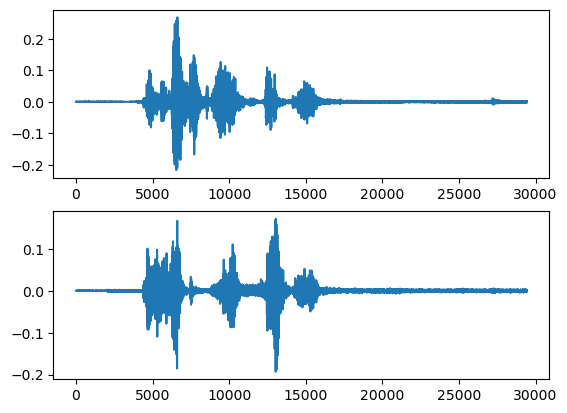

In [45]:
x_syn = glim_synt(xspg_wp.T,sample_rate=sr)
y_syn = glim_synt(yspg_wp.T,sample_rate=sr)
fig,ax = plt.subplots(2)
ax[0].plot(x_syn)
ax[1].plot(y_syn)
print("Original 'x'")
display(Audio(xwav,rate=sr))
print("Warped 'x'")
display(Audio(x_syn,rate=sr))
print("Original 'y'")
display(Audio(ywav,rate=sr))
print("Warped 'y'")
display(Audio(y_syn,rate=sr))
print("Duo Speech x_wp+y_wp")
display(Audio(x_syn+y_syn,rate=sr)) 